## Imports

In [1]:
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision.io import read_image, ImageReadMode
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import time
import os

from tempfile import TemporaryDirectory

In [2]:
# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


## Load data

In [3]:
class LabeledData(Dataset):
    def __init__(self, annotation_file, transform=None) -> None:
        self._annotations = pd.read_csv(annotation_file)
        self.labels = self._annotations["label"]
        self.images_path = self._annotations["sample"]
        self.transform = transform

    def __getitem__(self, idx):
        _path_to_image = os.path.join(DATA_PATH, self.images_path[idx])
        image = read_image(_path_to_image, ImageReadMode.RGB)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images_path)


class UnlabeledData(Dataset):
    def __init__(self) -> None:
        raise NotImplementedError

In [4]:
DATA_PATH = os.path.join(os.getcwd(), "data")

TASK1_PATH = os.path.join(DATA_PATH, "task1")
TRAIN_TASK1 = os.path.join(TASK1_PATH, "train_data","annotations.csv")
VAL_TASK1 = os.path.join(TASK1_PATH, "val_data")

TASK2_PATH = os.path.join(DATA_PATH, "task2")
TRAIN_TASK2 = os.path.join(TASK2_PATH, "train_data","annotations.csv")
VAL_TASK2 = os.path.join(TASK2_PATH, "val_data")

In [5]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
)

transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

In [6]:
dataset = LabeledData(TRAIN_TASK1)

In [7]:
def get_split_dataset(
    data,
    seed=42,
    test_size=0.2,
    batch_size = 64
):
    """Taken form https://stackoverflow.com/a/68338670"""
   
    # generate indices: instead of the actual data we pass in integers instead
    train_indices, test_indices, _, _ = train_test_split(
        range(len(data)),
        data.labels,
        stratify=data.labels,
        test_size=test_size,
        random_state=seed,
    )

    # generate subset based on indices
    train_split = Subset(data, train_indices)
    test_split = Subset(data, test_indices)

    # create batches
    train_batches = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    test_batches = DataLoader(test_split, batch_size=batch_size)


    return train_batches, test_batches

In [8]:
train_loader,valid_loader = get_split_dataset(dataset)

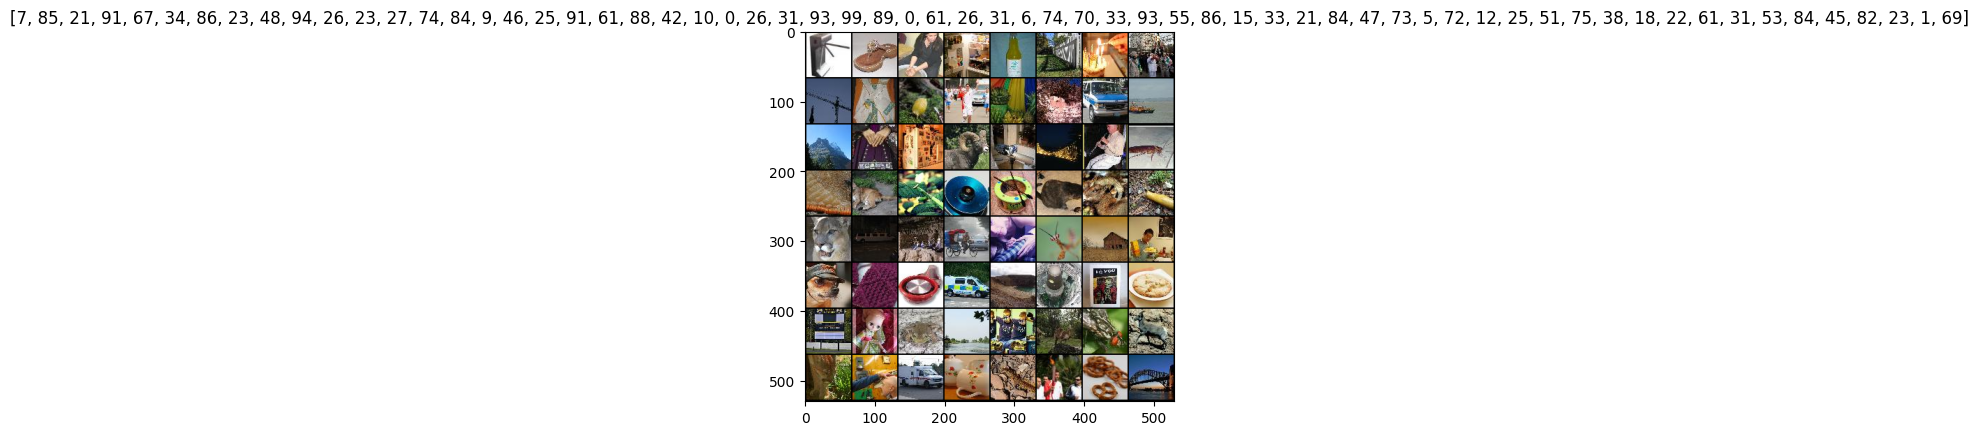

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    # plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x.item() for x in classes])

## Base model resnet50

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Training phase

            model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            scheduler.step()

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = running_corrects.double() / len(train_loader)

            print(f"Train\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            print()

            model.eval()

            running_loss = 0.0
            running_corrects = 0
            # Validation phase
            for inputs, labels in valid_loader:
                inputs = inputs.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(valid_loader)
            epoch_acc = running_corrects.double() / len(valid_loader)

            print(f"Valid\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model

In [38]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
model_ft = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 100)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10
)

Epoch 0/9
----------


: 

In [ ]:
visualize_model(model_ft)